<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preparation</a></span><ul class="toc-item"><li><span><a href="#Handling-missing-values" data-toc-modified-id="Handling-missing-values-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Handling missing values</a></span></li><li><span><a href="#Useless-features" data-toc-modified-id="Useless-features-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Useless features</a></span></li><li><span><a href="#Anomalies-handling" data-toc-modified-id="Anomalies-handling-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Anomalies handling</a></span></li><li><span><a href="#Check-for-duplicates" data-toc-modified-id="Check-for-duplicates-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Check for duplicates</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></li><li><span><a href="#Model-Training" data-toc-modified-id="Model-Training-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model Training</a></span><ul class="toc-item"><li><span><a href="#Data-split" data-toc-modified-id="Data-split-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Data split</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#ElasticNet" data-toc-modified-id="ElasticNet-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>ElasticNet</a></span></li></ul></li><li><span><a href="#Model-Analysis" data-toc-modified-id="Model-Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model Analysis</a></span></li><li><span><a href="#Testing-the-best-model" data-toc-modified-id="Testing-the-best-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Testing the best model</a></span></li><li><span><a href="#Sanity-Check" data-toc-modified-id="Sanity-Check-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Sanity Check</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

# Determining the car price

Service that sells used cars "XYZ" is developing an application to attract new customers. Using that app, you can quickly find out the market value of your car. At our disposal are historical data: technical specifications, equipment and prices of cars. We need to build a model to determine the price.

The customer requirements:

- quality of prediction;
- prediction speed;
- training time.

The purpose of the project: To build a model for a regression problem that will predict the market value of a car.

Project steps:

1. Review and preparation of data.
2. Model training.
3. Model analysis.
4. Testing the best model.
5. Sanity Check

## Data preparation

In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings

from catboost import CatBoostRegressor
from scipy import stats as st
from sklearn.dummy import DummyRegressor
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

In [2]:
try:
    df = pd.read_csv('autos.csv')
except: 
    print('Something is wrong')

In [3]:
warnings.filterwarnings("ignore")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


So, we have a table with data.

According to the data documentation:

Features:

* `DateCrawled` — date of downloading the questionnaire from the database
* `VehicleType` — car body type
* `RegistrationYear` - year of car registration
* `Gearbox` — gear box type
* `Power` - power (hp)
* `Model` — car model
* `Kilometer` — mileage (km)
* `RegistrationMonth` — car registration month
* `FuelType` — fuel type
* `Brand` — car brand
* `NotRepaired` - was the car under repair or not
* `DateCreated` — date of creation of the questionnaire
* `NumberOfPictures` - the number of photos of the car
* `PostalCode` — postal code of the owner of the profile (user)
* `LastSeen` — date of last user activity

Target variable:

* `Price` — price (euro)

Let's convert the column names to lowercase and convert some of them to snake case 

In [6]:
df.columns = df.columns.str.replace(r"([A-Z])", r" \1", regex=True).str.lower().str.replace(' ', '_').str[1:]

In [7]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Let's create histograms and look at the distribution of features.

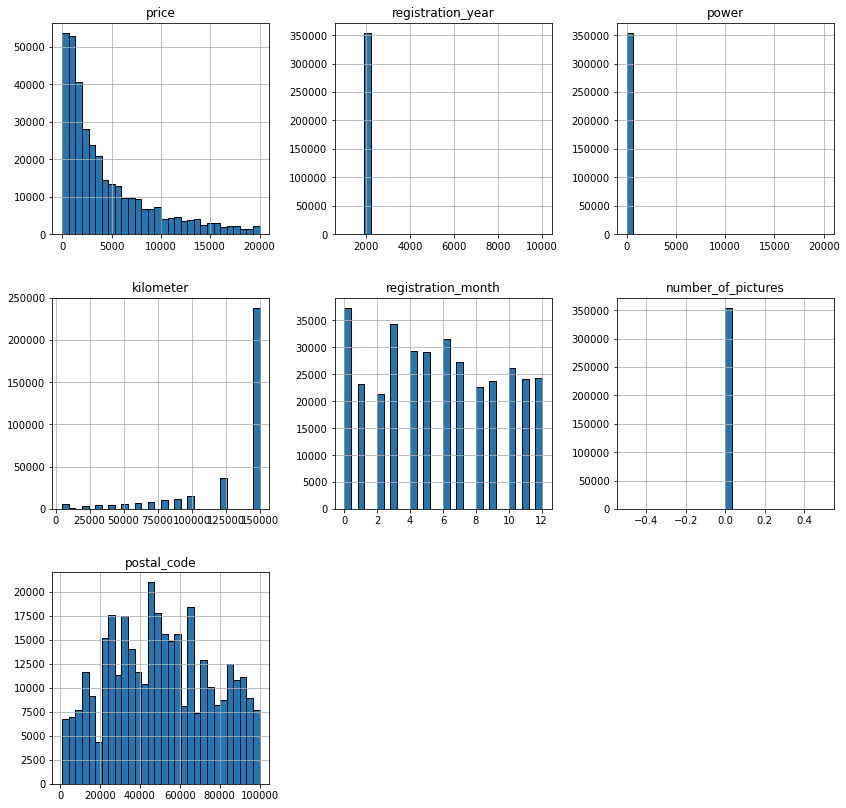

In [8]:
df.hist(bins=30, figsize=(14,14), edgecolor='black', linewidth=1)
plt.show()

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
registration_year,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
number_of_pictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
postal_code,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


The graphs show that there are anomalies and outliers in the data that require further processing. Let's look at the correlations between features.

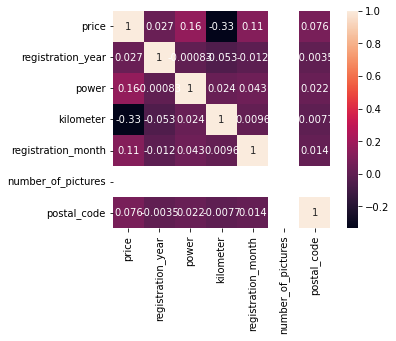

In [10]:
sns.heatmap(df.corr(), annot=True, square=True)
plt.show()

There is a weak negative correlation (-0.33) between mileage and price.

### Handling missing values

Let's check the number of missing values.

In [11]:
pd.DataFrame(data=(df.isna().sum(), df.isna().mean()), index=['sum', 'mean']).T.sort_values(by='mean', ascending=False)

,sum,mean
not_repaired,71154.0,0.200791
vehicle_type,37490.0,0.105794
fuel_type,32895.0,0.092827
gearbox,19833.0,0.055967
model,19705.0,0.055606
date_crawled,0.0,0.000000
price,0.0,0.000000
registration_year,0.0,0.000000
power,0.0,0.000000
kilometer,0.0,0.000000


We have a large number of missing values (20%) in the `not_repaired` column. This may be because the user did not report the repair, or due to a technical error.  

There are also a lot of missing values in the following columns: `vehicle_type` (10.6%), `fuel_type` (9.3%), `gearbox` (5.6%), and `model` (5.6%). Missing values in these columns could also appear either as a result of user errors when filling out the ad or as a result of a technical error.

Since all features with missing values are categorical, we will replace them with the `unknown` type. 

In [12]:
df_new = df.fillna('unknown')

In [13]:
df_new.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

### Useless features

Let's remove features such as: the date the profile was downloaded from the database (`date_crawled`), the date the profile was created (`date_created`), the date of the last user activity (`last_seen`), the number of car photos (`number_of_pictures`) (contains only `0` values in all ads), the postal code of the owner of the profile (user) (`postal_code`) and the month of registration of the car (`registration_month`), since they are not useful for our project.

In [14]:
df_new = df_new.drop(
    ['date_crawled', 
     'date_created', 
     'last_seen', 
     'number_of_pictures', 
     'postal_code', 
     'registration_month'], axis=1)

In [15]:
df_new.head(5)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


### Anomalies handling 

Let's take another look at the distribution of values in columns with numeric data.

In [16]:
df_new.describe().T

,count,mean,std,min,25%,50%,75%,max
price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
registration_year,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0


In [17]:
df['date_created'].max()

'2016-04-07 00:00:00'

There are null values in the `price` and `power` columns. Also, the maximum engine power is 20,000 hp. looks unrealistic and is most likely a data entry error. Anomalies are also observed in the `registration_year` column: the minimum year of registration is 1000 and the maximum is 9999. Since the year of data upload is 2016, the year of registration of the car cannot be higher than this value. To continue the project it is necessary to get rid of anomalies. We will remove values below the 1st percentile and above the 99th percentile, and for the year of registration, we will limit the data to 2016. 

In [18]:
df_clean = df_new.loc[
    (df_new['registration_year'] > df_new['registration_year'].quantile(0.01)) & 
    (df_new['registration_year'] <= 2016) & 
    (df_new['power'] > df_new['power'].quantile(0.01)) & 
    (df_new['power'] <= df_new['power'].quantile(0.99)) & 
    (df_new['price'] > df_new['price'].quantile(0.01)) & 
    (df_new['price'] <= df_new['price'].quantile(0.99))
]
df_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
price,288278.0,4609.850079,4309.514546,1.0,1300.0,3000.0,6700.0,18800.0
registration_year,288278.0,2002.999299,5.858523,1981.0,1999.0,2003.0,2007.0,2016.0
power,288278.0,117.867881,48.315132,1.0,75.0,110.0,145.0,300.0
kilometer,288278.0,128949.971902,36183.351011,5000.0,125000.0,150000.0,150000.0,150000.0


Thus, we got rid of anomalies. Let's see how much data we have left after filtering.

In [19]:
print(f'{df_clean.shape[0]/df.shape[0]:.2%}')

81.35%


### Check for duplicates

Let's check the data for duplicates.

In [20]:
df_clean.duplicated().sum()

38492

We have found 38492 duplicate values. This is probably due to some technical problem or data entry error. Let's remove duplicate values to improve model training.

In [21]:
df_clean = df_clean.drop_duplicates()

In [22]:
df_clean.duplicated().sum()

0

Thus, we removed the duplicates and can move on.

### Conclusion

Our dataset consists of 354369 observations and 16 columns. Each object in the dataset is information about the technical characteristics, equipment and prices of cars.

During the data preparation step we did the following:

* converted column names to lowercase and converted some of them to snake case
* filled in missing values with 'unknown'
* removed unnecessary features such as `date_crawled`, `date_created`, `last_seen`, `number_of_pictures`, `postal_code` and `registration_month` as they are not useful for analysis and training of models
* removed the rows with anomalous values in columns `registration_year`, `power` and `price`
* removed duplicates

## Model Training

### Data split

Let's divide the dataset into features and a target variable.

In [23]:
features = df_clean.drop('price', axis=1)
target = df_clean['price']

In [24]:
print('Features size:',features.shape)
print('Target variable size:',target.shape)

Features size: (249786, 9)
Target variable size: (249786,)


Let's split the data into two sets: training and test. We will use the training set to train the model and tune the hyperparameters, and the test set to test the model.

In [25]:
X_train , X_test , y_train , y_test = train_test_split (
    features, target, test_size = .25,
    random_state = 12345
)

In [26]:
print('Features size of training set:', X_train.shape), 
print('Target size of training set:', y_train.shape), 
print('Features size of validation set:', X_test.shape), 
print('Target size of validation set:', y_test.shape)

Features size of training set: (187339, 9)
Target size of training set: (187339,)
Features size of validation set: (62447, 9)
Target size of validation set: (62447,)


We split the data into two sets in a ratio of 75 to 25:

     X_train, y_train - training set
     X_test, y_test - test set

Let's create lists in order to add model results to them. After the end of the tests, we will create a table and analyze the results.

In [27]:
training_time = []
prediction_time = []
model_rmse = []
model_name = []

### RandomForestRegressor

Before training the `Random Forest` model, let's scale the numeric variables with the Standard Scaler and encode the categorical variables with the Ordinal Encoder.

Let's separate categorical and numerical columns.

In [28]:
cat_features = list(X_train.select_dtypes(include=['object']).columns)
cat_features

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

In [29]:
num_features = list(set(X_train.columns) - set(cat_features))
num_features

['power', 'registration_year', 'kilometer']

Let's create a transformer that will scale numerical variables and encode categorical variables.

In [30]:
numeric_transformer = StandardScaler()
categorical_transformer = OrdinalEncoder (handle_unknown='use_encoded_value', unknown_value=np.nan)
preprocessor = ColumnTransformer (
    transformers = [
        ('num' , numeric_transformer , num_features) ,
        ('cat' , categorical_transformer , cat_features) ]
    )

In order to correctly calculate the training time of the `Random Forest` model, let's calculate the total time required to transform the variables and train the model.

In [31]:
st_data_transform = time.time()

X_train_reg = preprocessor.fit_transform(X_train)
X_test_reg  = preprocessor.transform(X_test)

et_data_transform = time.time()
elapsed_time_data_transform = et_data_transform - st_data_transform

**Hyperparameter tuning and model training**

Let's tune hyperparameters using GridSearchCV and train the model.

In [32]:
random_forest_params = {'n_estimators': [10, 20, 30], 
                        'max_features': ['auto', 'sqrt', 'log2'], 
                        'max_depth' : [4,5,6,7,8]}
random_forest = RandomForestRegressor(random_state=12345)

grid_forest = GridSearchCV(random_forest, random_forest_params, cv=5, scoring='neg_root_mean_squared_error')
grid_forest.fit(X_train_reg, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 20, 30]},
             scoring='neg_root_mean_squared_error')

Let's train the model using the best parameters and measure the training time.

In [33]:
st_rf_train = time.time()

rf_model = RandomForestRegressor(**grid_forest.best_params_, random_state=12345)
rf_model.fit(X_train_reg, y_train)

et_rf_train = time.time()
elapsed_time_rf_train = et_rf_train - st_rf_train + elapsed_time_data_transform

Let's check the model on the training data and evaluate the quality using the RMSE.

In [34]:
st_rf_pred = time.time()

rf_pred = rf_model.predict(X_train_reg)
rmse_rf = mean_squared_error(y_train, rf_pred, squared=False)
print(f'The best RMSE for Random Forest: {rmse_rf}')

et_rf_pred = time.time()
elapsed_time_rf_pred = et_rf_pred - st_rf_pred

The best RMSE for Random Forest: 1867.5529717637478


In [35]:
model_name.append('RandomForest')
training_time.append(elapsed_time_rf_train)
prediction_time.append(elapsed_time_rf_pred)
model_rmse.append(rmse_rf)

### LightGBM

Since the LightGBM library can work with categorical data, there is no need to encode it. At the same time, for the model to work correctly, we need to change the data type from object to category. First, let's tune hyperparameters using GridSearchCV, and then train the model and measure the time required for training and prediction.

In [36]:
lgbm_features = list(X_train.columns)
lgbm_features

['vehicle_type',
 'registration_year',
 'gearbox',
 'power',
 'model',
 'kilometer',
 'fuel_type',
 'brand',
 'not_repaired']

In [37]:
X_train_lgbm = X_train.copy()

In [38]:
# change categorical columns to category type
X_train_lgbm[cat_features] = X_train_lgbm[cat_features].apply(lambda x: x.astype('category'))

# prepare the data
train_data = lgb.Dataset (X_train_lgbm, 
                          label = y_train, 
                          feature_name = lgbm_features, 
                          categorical_feature = cat_features)

# create a parameter grid
lgb_params = {'learning_rate': [0.2, 0.5], 'num_iterations': [100, 200]}


lgb_model = lgb.LGBMRegressor(random_state=12345)
grid_lgbm = GridSearchCV(lgb_model, lgb_params, cv=5, scoring='neg_root_mean_squared_error', verbose=20, n_jobs=-1) 
grid_lgbm.fit(X_train_lgbm, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=12345), n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.5],
                         'num_iterations': [100, 200]},
             scoring='neg_root_mean_squared_error', verbose=20)

Let's train the model using the best parameters and measure the training time.

In [39]:
st_lgbm_train = time.time()


lgb_model = lgb.train(grid_lgbm.best_params_, train_data)


et_lgbm_train = time.time()
elapsed_time_lgbm_train = et_lgbm_train - st_lgbm_train

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 545
[LightGBM] [Info] Number of data points in the train set: 187339, number of used features: 9
[LightGBM] [Info] Start training from score 4683.650676


Let's check the model on the training data and evaluate the quality using the RMSE.

In [40]:
st_lgbm_pred = time.time()

lgbm_pred = lgb_model.predict(X_train_lgbm)
rmse_lgbm = mean_squared_error(y_train, lgbm_pred, squared=False)

print(f'RMSE of LightGBM: {rmse_lgbm}')

et_lgbm_pred = time.time()
elapsed_time_lgbm_pred = et_lgbm_pred - st_lgbm_pred

RMSE of LightGBM: 1372.777224664424


In [41]:
model_name.append('LightGBM')
training_time.append(elapsed_time_lgbm_train)
prediction_time.append(elapsed_time_lgbm_pred)
model_rmse.append(rmse_lgbm)

### CatBoost

For the CatBoost model, we don't need to encode categorical features and also change their type. To begin with, let's tune hyperparameters using GridSearchCV, and then train the model and measure the time required for training and prediction.

In [42]:
grid_catboost_params = {'learning_rate': [0.2, 0.4], 
                 'depth': [4, 6, 10], 
                 'iterations': [100, 200], 
                 'verbose': [20], 
                 'random_seed': [12345]}

grid_catboost_model = CatBoostRegressor(cat_features=cat_features)
grid_catboost = GridSearchCV(grid_catboost_model, grid_catboost_params, cv=5, scoring='neg_root_mean_squared_error')
grid_catboost.fit(X_train, y_train)


0:	learn: 3851.0410132	total: 229ms	remaining: 22.7s
20:	learn: 1883.8314187	total: 1.58s	remaining: 5.96s
40:	learn: 1755.6009489	total: 2.75s	remaining: 3.95s
60:	learn: 1698.2941267	total: 3.9s	remaining: 2.5s
80:	learn: 1664.4675256	total: 5.03s	remaining: 1.18s
99:	learn: 1645.1139123	total: 6.04s	remaining: 0us
0:	learn: 3843.5910430	total: 63.5ms	remaining: 6.29s
20:	learn: 1876.8862192	total: 1.17s	remaining: 4.42s
40:	learn: 1761.7768370	total: 2.25s	remaining: 3.25s
60:	learn: 1700.5991496	total: 3.31s	remaining: 2.12s
80:	learn: 1667.1870325	total: 4.37s	remaining: 1.02s
99:	learn: 1645.0655362	total: 5.37s	remaining: 0us
0:	learn: 3855.9750273	total: 68.6ms	remaining: 6.79s
20:	learn: 1888.4369360	total: 1.18s	remaining: 4.43s
40:	learn: 1762.8012552	total: 2.24s	remaining: 3.23s
60:	learn: 1710.5999768	total: 3.34s	remaining: 2.14s
80:	learn: 1675.0739710	total: 4.44s	remaining: 1.04s
99:	learn: 1648.6753879	total: 5.44s	remaining: 0us
0:	learn: 3849.7681841	total: 68.9ms	

100:	learn: 1587.9429303	total: 10.4s	remaining: 10.2s
120:	learn: 1573.5967339	total: 12.4s	remaining: 8.12s
140:	learn: 1562.8313155	total: 14.4s	remaining: 6.01s
160:	learn: 1552.2410401	total: 16.4s	remaining: 3.98s
180:	learn: 1544.9653545	total: 18.3s	remaining: 1.93s
199:	learn: 1539.3530908	total: 20.2s	remaining: 0us
0:	learn: 3417.6553209	total: 130ms	remaining: 26s
20:	learn: 1746.6889522	total: 2.2s	remaining: 18.7s
40:	learn: 1667.0741349	total: 4.18s	remaining: 16.2s
60:	learn: 1622.1383140	total: 6.21s	remaining: 14.2s
80:	learn: 1599.7268423	total: 8.39s	remaining: 12.3s
100:	learn: 1579.0486313	total: 10.7s	remaining: 10.5s
120:	learn: 1563.9157816	total: 13s	remaining: 8.5s
140:	learn: 1552.3893820	total: 15.2s	remaining: 6.35s
160:	learn: 1542.3795560	total: 17.1s	remaining: 4.15s
180:	learn: 1535.4356591	total: 19.4s	remaining: 2.04s
199:	learn: 1527.3735974	total: 21.4s	remaining: 0us
0:	learn: 3795.1322433	total: 83.9ms	remaining: 8.31s
20:	learn: 1767.1651929	tot

199:	learn: 1448.7456989	total: 34.7s	remaining: 0us
0:	learn: 3285.5923471	total: 194ms	remaining: 38.7s
20:	learn: 1667.2691917	total: 4.83s	remaining: 41.2s
40:	learn: 1591.1655611	total: 10.1s	remaining: 39s
60:	learn: 1550.9551989	total: 13.6s	remaining: 31s
80:	learn: 1524.6621558	total: 16.9s	remaining: 24.8s
100:	learn: 1508.9896816	total: 20.2s	remaining: 19.8s
120:	learn: 1497.2014263	total: 23.4s	remaining: 15.3s
140:	learn: 1485.0986485	total: 26.5s	remaining: 11.1s
160:	learn: 1473.6934508	total: 29.9s	remaining: 7.25s
180:	learn: 1464.5761893	total: 33.5s	remaining: 3.52s
199:	learn: 1456.4669541	total: 37s	remaining: 0us
0:	learn: 3281.5782033	total: 208ms	remaining: 41.3s
20:	learn: 1658.9288851	total: 3.52s	remaining: 30s
40:	learn: 1581.4060939	total: 6.93s	remaining: 26.9s
60:	learn: 1543.7571333	total: 10.1s	remaining: 23s
80:	learn: 1519.3951035	total: 13.3s	remaining: 19.6s
100:	learn: 1503.1360567	total: 16.6s	remaining: 16.3s
120:	learn: 1491.6329146	total: 20.2

80:	learn: 1379.0627624	total: 27.5s	remaining: 40.4s
100:	learn: 1349.2544271	total: 34.7s	remaining: 34s
120:	learn: 1330.2621691	total: 42.3s	remaining: 27.6s
140:	learn: 1311.8865370	total: 49.9s	remaining: 20.9s
160:	learn: 1295.6339433	total: 57.4s	remaining: 13.9s
180:	learn: 1279.8453936	total: 1m 4s	remaining: 6.77s
199:	learn: 1268.4588831	total: 1m 11s	remaining: 0us
0:	learn: 3144.0808326	total: 326ms	remaining: 1m 4s
20:	learn: 1522.4738662	total: 6.83s	remaining: 58.3s
40:	learn: 1447.0747806	total: 14.2s	remaining: 55.1s
60:	learn: 1407.7976526	total: 21.2s	remaining: 48.4s
80:	learn: 1374.7148244	total: 28.3s	remaining: 41.6s
100:	learn: 1350.3086362	total: 36.3s	remaining: 35.6s
120:	learn: 1331.4334216	total: 43.6s	remaining: 28.5s
140:	learn: 1309.9377438	total: 51s	remaining: 21.4s
160:	learn: 1291.2327995	total: 58.6s	remaining: 14.2s
180:	learn: 1278.1320671	total: 1m 6s	remaining: 6.95s
199:	learn: 1264.8800989	total: 1m 13s	remaining: 0us
0:	learn: 3151.5829021	

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x0000025DE9F6CB50>,
             param_grid={'depth': [4, 6, 10], 'iterations': [100, 200],
                         'learning_rate': [0.2, 0.4], 'random_seed': [12345],
                         'verbose': [20]},
             scoring='neg_root_mean_squared_error')

Let's train the model using the best parameters and measure the training time.

In [43]:
st_catboost_train = time.time()

cat_model = CatBoostRegressor(**grid_catboost.best_params_, cat_features=cat_features)

cat_model.fit(X_train, y_train)

et_catboost_train = time.time()
elapsed_time_catboost_train = et_catboost_train - st_catboost_train

0:	learn: 3713.2338102	total: 389ms	remaining: 1m 17s
20:	learn: 1610.3728329	total: 8.51s	remaining: 1m 12s
40:	learn: 1518.6769281	total: 17s	remaining: 1m 5s
60:	learn: 1473.5875212	total: 25.4s	remaining: 57.9s
80:	learn: 1444.7226679	total: 34.2s	remaining: 50.2s
100:	learn: 1423.3009173	total: 43.3s	remaining: 42.4s
120:	learn: 1403.7716848	total: 52.2s	remaining: 34.1s
140:	learn: 1387.8488842	total: 1m 1s	remaining: 25.6s
160:	learn: 1376.7045540	total: 1m 10s	remaining: 17.1s
180:	learn: 1365.4675541	total: 1m 19s	remaining: 8.36s
199:	learn: 1356.0416686	total: 1m 28s	remaining: 0us


Let's check the model on the training data and evaluate the quality using the RMSE.

In [44]:
st_catboost_pred = time.time()

catboost_pred = cat_model.predict(X_train)
rmse_catboost = mean_squared_error(y_train, catboost_pred, squared=False)
print(f'RMSE of Catboost: {rmse_catboost}')

et_catboost_pred = time.time()
elapsed_time_catboost_pred = et_catboost_pred - st_catboost_pred

RMSE of Catboost: 1372.1444200808303


In [45]:
model_name.append('CatBoost')
training_time.append(elapsed_time_catboost_train)
prediction_time.append(elapsed_time_catboost_pred)
model_rmse.append(rmse_catboost)

### ElasticNet

First, we tune hyperparameters using GridSearchCV, and then train the ElasticNet model and measure the time required for training and prediction. For the fair comparison, we will include the time required for encoding categorical features and scaling numerical ones in the total training time of the model.

In [46]:
eln_params = {'alpha': (.01, .5, .05), 
                        'l1_ratio': (.1, .9, .1)}
elastic_net = ElasticNet(random_state=12345)
grid_eln = GridSearchCV(elastic_net, eln_params, cv=5, scoring='neg_root_mean_squared_error')

grid_eln.fit(X_train_reg, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(random_state=12345),
             param_grid={'alpha': (0.01, 0.5, 0.05),
                         'l1_ratio': (0.1, 0.9, 0.1)},
             scoring='neg_root_mean_squared_error')

In [47]:
st_eln_train = time.time()

eln_model = ElasticNet(**grid_eln.best_params_, random_state=12345)
eln_model.fit(X_train_reg, y_train)

et_eln_train = time.time()
elapsed_time_eln_train = et_eln_train - st_eln_train

In [48]:
st_eln_pred = time.time()

eln_pred = eln_model.predict(X_train_reg)

rmse_eln = mean_squared_error(y_train, eln_pred, squared=False)
print(f'The best RMSE for ElasticNet: {rmse_eln}')

et_eln_pred = time.time()
elapsed_time_eln_pred = et_eln_pred - st_eln_pred

The best RMSE for ElasticNet: 2668.886293931846


In [49]:
model_name.append('ElasticNet')
training_time.append(elapsed_time_eln_train)
prediction_time.append(elapsed_time_eln_pred)
model_rmse.append(rmse_eln)

## Model Analysis

Let's create a table with the results and compare the models.

In [50]:
model_comparison = pd.DataFrame(
    {
    'model_name': model_name, 
    'training_time, sec': training_time, 
    'prediction_time, sec': prediction_time, 
    'RMSE': model_rmse
    }
).sort_values(by='RMSE').reset_index(drop=True)

model_comparison.style.highlight_min(
    ['RMSE', 'prediction_time, sec', 'training_time, sec'], 
    color='lightgreen', 
    axis=0
)

,model_name,"training_time, sec","prediction_time, sec",RMSE
0,CatBoost,90.112482,1.034526,1372.144420
1,LightGBM,1.908197,1.064368,1372.777225
2,RandomForest,3.743850,0.501338,1867.552972
3,ElasticNet,0.080441,0.008021,2668.886294


The `LightGBM` and `Catboost` models showed equally good prediction quality, outperforming `Random Forest Regressor` and `ElasticNet`. At the same time, the training time of `LightGBM` is much lower than that of `CatBoost`, and the prediction time is higher. The `ElasticNet` model turned out to be the fastest in terms of learning and prediction, but its prediction quality is the lowest.

Let's check feature importance for LightGBM model.

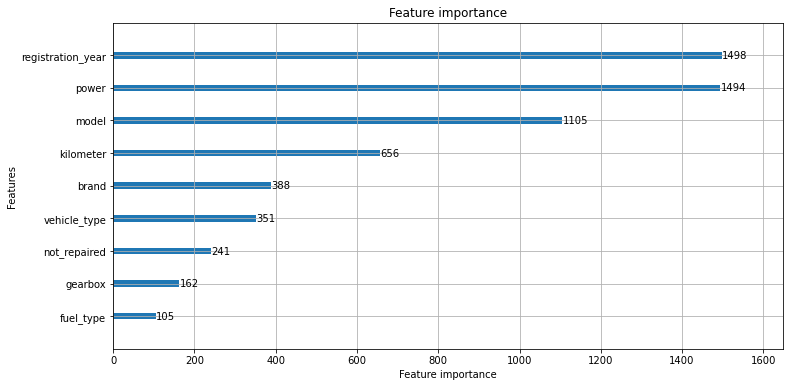

In [51]:
lgb.plot_importance(lgb_model, figsize = (12, 6))
plt.show()

`Year of registration` is on the first place, the `power` is second and the `car model` closes the top three.

Let's look at the importance of features for the CatBoost model.

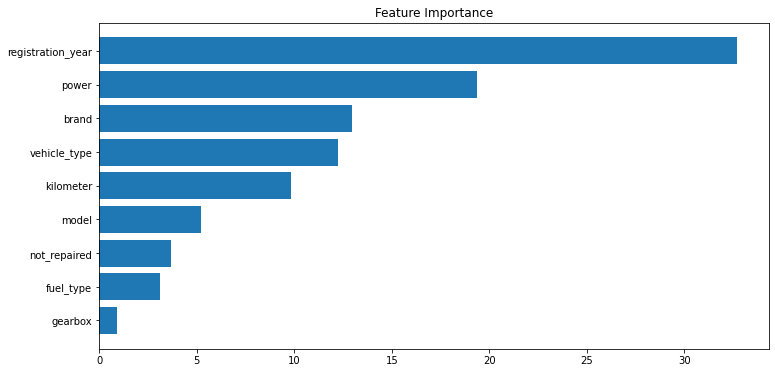

In [52]:
feature_importance = cat_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

For the CatBoost model, the most important are: the `year of registration`, `power` and `brand`.

**Conclusion**

The `LightGBM` model showed the best result in terms of prediction quality, model training time, and model prediction time. Let's test it on the new data. 

## Testing the best model

**LightGBM**

Let's check how the model performs on the test data.

In [53]:
X_test_lgbm = X_test.copy()

In [54]:
st_lgbm_test = time.time()

X_test_lgbm[cat_features] = X_test_lgbm[cat_features].apply(lambda x: x.astype('category'))


lgbm_pred = lgb_model.predict(X_test_lgbm)
rmse_lgbm = mean_squared_error(y_test, lgbm_pred, squared=False)

print(f'RMSE of LightGBM on the test data: {rmse_lgbm}')

et_lgbm_test = time.time()
elapsed_time_lgbm_test = et_lgbm_test - st_lgbm_test

RMSE of LightGBM on the test data: 1469.5039355550798


## Sanity Check

Let's check the model for adequacy by comparing the RMSE of the trained model with the RMSE of the constant model (mean). To do this, we use the DummyRegressor from the sklearn library.

In [55]:
dummy = DummyRegressor(strategy = 'mean')
dummy.fit(X_train, y_train)
dummy_predictions = dummy.predict(X_test)
rmse_dummy = mean_squared_error(y_test, dummy_predictions, squared=False)
print(f'RMSE of the constant model: {rmse_dummy}')

RMSE of the constant model: 4351.352727898366


All trained models passed sanity check, as their RMSE is lower than that of the constant model.

## Conclusion

In the course of the project, we reviewed the data, checked the distributions of values and correlations, replaced the missing values in the columns with `unknown` values, and also removed features that were not useful, such as `date_crawled`, `date_created`, `last_seen`, ` number_of_pictures`, `postal_code` and `registration_month`. We got rid of rows with anomalous values in the columns `registration_year`, `power` and `price`, and also removed duplicates.

After that, we divided the data into two sets (training and test) in the proportion of 75:25. Then we encoded categorical features and scaled numerical features. After that we trained `Random Forest`, `LightGBM`, `CatBoost` and `ElasticNet` models. We checked the quality of the models on test data using the RMSE metric, and also measured the training and prediction times of the models.

`LightGBM` and `CatBoost` models showed the best RMSE result (1372). However, the training time of the `LightGBM` model (1.91 sec) is much lower than that of `CatBoost` (90.1 sec). `ElasticNet` model has the best prediction time (0.008 sec), but the prediction quality is very low (RMSE - 2668.89).

Based on customer requirements - the best model in terms of a combination of factors will be based on the `LightGBM` library.